In [1]:
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import lfimodels.hodgkinhuxley.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from lfimodels.hodgkinhuxley.HodgkinHuxley import HodgkinHuxley
from lfimodels.hodgkinhuxley.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments
from run_genetic import run_deap

%matplotlib inline

## Set up the model

In [2]:
true_params, labels_params = utils.obs_params()

labels_sum_stats = ['sp_t','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9',
                    'r_pot','mn','m2','m3','m4','m5','m6','m7','m8']

seed = 1
prior_log = False
prior_extent = True
n_mom = 7
cython=True

I, t_on, t_off, dt = utils.syn_current()

obs = utils.syn_obs_data(I, dt, true_params, seed=seed, cython=cython)
obs_stats = utils.syn_obs_stats(I=I, t_on=t_on, t_off=t_off, dt=dt, params=true_params,
                                seed=seed, n_mom=n_mom, cython=cython)

# estimate resting potential
E_leak = utils.resting_potential(obs['data'],dt,t_on)

m = HodgkinHuxley(I, dt, E_leak=E_leak, seed=seed, cython=cython,prior_log=prior_log)
p = utils.prior(true_params=true_params, prior_extent=prior_extent,prior_log=prior_log, seed=seed)
s = HodgkinHuxleyStatsMoments(t_on=t_on, t_off=t_off)
g = dg.Default(model=m, prior=p, summary=s)

bounds = np.asarray([p.lower,p.upper]).T

## pilot run

In [3]:
seed = 1
svi = False
res = infer.SNPE(g, obs=obs_stats, pilot_samples=1000, n_hiddens=[50], seed=seed, prior_norm=True,
                 n_components=1, svi=svi)

## Run genetic algorithm

In [6]:
algo = 'ibea'
offspring_size = 100
max_ngen = 100
final_pop, halloffame, log, hist = run_deap(model=m, bounds=bounds, labels_params=labels_params,
                                            summary=s, obs_stats=obs_stats, labels_sum_stats=labels_sum_stats,
                                            stats_std=res.stats_std,
                                            algo=algo, offspring_size=offspring_size, max_ngen=max_ngen, seed=seed)

## Inspect output

In [7]:
best_params = halloffame[0]
best_sumstats = best_params.fitness.values

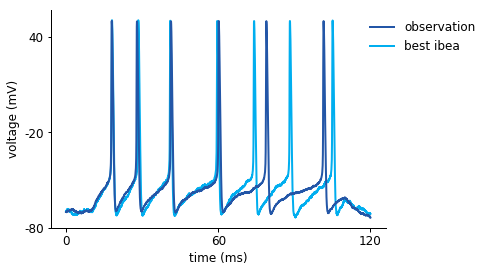

In [8]:
fig = plt.figure()

n_params = len(bounds[:,0])
n_sum_stats = len(obs_stats[0,:])
y_obs = obs['data']
t = obs['time']
duration = np.max(t)

COL = {}
COL['GT']   = (35/255,86/255,167/255)
COL['IBEA'] = (0, 174/255,239/255)

x = m.gen_single(best_params)
V_best = x['data']

# plotting simulation
plt.plot(t, V_best, color=COL['IBEA'], lw=2, label='best ibea')
plt.plot(t, y_obs, color=COL['GT'], lw=2, label='observation')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc='upper right')

ax.set_xticks([0, duration/2, duration])
ax.set_yticks([-80, -20, 40]);

## Analysis of optimization

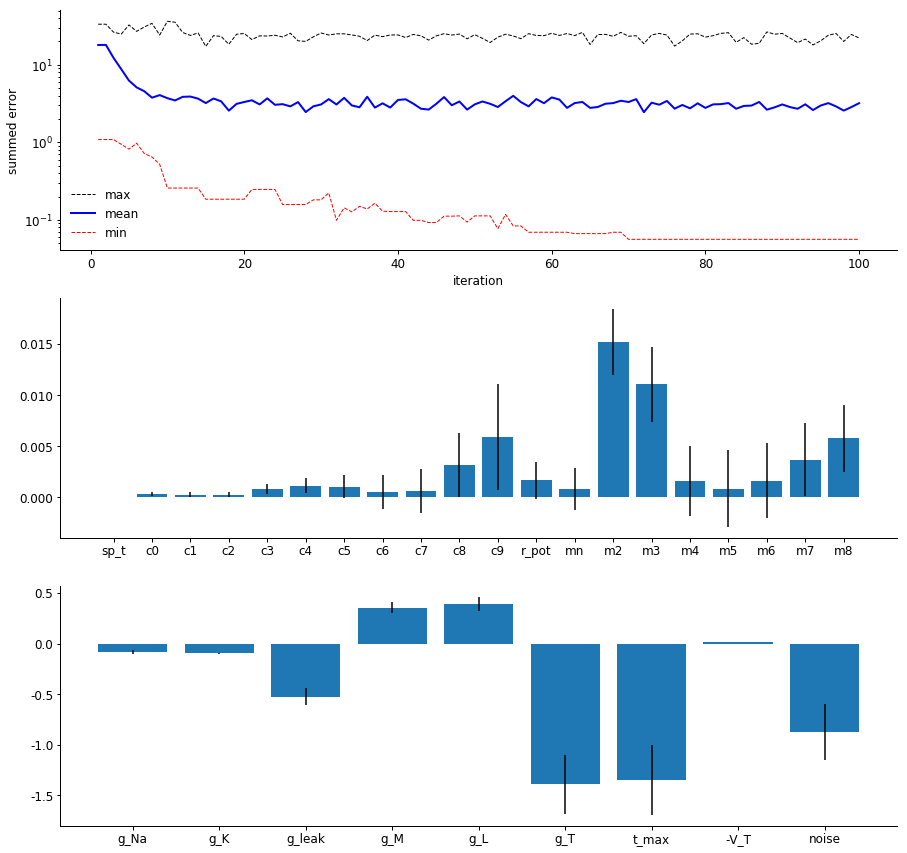

In [9]:
fig = plt.figure(figsize=(15,15))

# error across iterations
plt.subplot(311)
plt.semilogy(log.select('gen'), log.select('max'), '--k', lw=1, label='max')
plt.semilogy(log.select('gen'), log.select('avg'), 'b', lw=2, label='mean')
plt.semilogy(log.select('gen'), log.select('min'), '--r', lw=1, label='min')
plt.xlabel('iteration')
plt.ylabel('summed error')
plt.legend(frameon=False)

obs_stats_2 = obs_stats / res.stats_std


###############################################################################
# histogram of differences between true summary features and final range of summary features

diff_sum_stats = np.divide(best_sumstats,np.abs(obs_stats_2))

all_best_sum_stats = np.zeros((len(halloffame[0].fitness.values),len(halloffame)))
for i in range(len(halloffame)):
    all_best_sum_stats[:,i] = halloffame[i].fitness.values


err_sum_stats_up_norm = np.divide( np.std(all_best_sum_stats,1) , np.abs(obs_stats_2) )
err_sum_stats_down_norm = np.divide( np.std(all_best_sum_stats,1) , np.abs(obs_stats_2) )

labels_sum_stats = labels_sum_stats[0:n_sum_stats]
                
plt.subplot(312)
plt.bar(np.linspace(0,len(labels_sum_stats)-1,len(labels_sum_stats)),diff_sum_stats[0], align='center',
        yerr=[err_sum_stats_down_norm[0],err_sum_stats_up_norm[0]])

ax = plt.gca()
ax.set_xticks(np.linspace(0,len(labels_sum_stats)-1,len(labels_sum_stats)))
ax.set_xticklabels(labels_sum_stats)


###############################################################################
# histogram of differences between true parameters and final parameter range

diff_params = np.divide(true_params-best_params,true_params)

err_params_up_norm = np.divide( np.std(halloffame,0) , true_params )
err_params_down_norm = np.divide( np.std(halloffame,0) , true_params )

labels_params = labels_params[0:len(true_params)]
                
plt.subplot(313)
plt.bar(np.linspace(0,len(labels_params)-1,len(labels_params)),diff_params, align='center',
        yerr=[err_params_down_norm,err_params_up_norm])
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(labels_params)-1,len(labels_params)))
ax.set_xticklabels(labels_params);